In [143]:
import random
from collections import namedtuple
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm import trange

In [144]:
np.random.seed(42)
random.seed(42)

In [145]:
ACTION_TAKE_MORE = 'hit'
ACTION_STOP_TAKING = 'stick'
COLOR_BLACK = 'black'
COLOR_RED = 'red'


@dataclass
class Card:
    number: int
    color: str


def get_new_card():
    number = random.randint(1, 10)

    color = np.random.choice(
        [COLOR_RED, COLOR_BLACK],
        1,
        p=[1/3, 2/3]
    )[0]

    return Card(number, color)

def apply_new_card_to_state(s, card, player):
    taker_sum, player_sum = s
    delta = card.number * \
                (-1 if card.color == COLOR_RED else 1)
    if player:
        return taker_sum, player_sum + delta
    else:
        return taker_sum + delta, player_sum

def calc_reward_on_take_more(s):
    _, player_sum = s

    if player_sum < 0 or player_sum > 21:
        return -1
    else:
        return 0


def take_cards_as_taker(s):
    taker_sum, player_sum = s
    while 0 <= taker_sum < 17:
        new_card = get_new_card()
        taker_sum, _ = apply_new_card_to_state(
            (taker_sum, player_sum),
            new_card,
            False
        )
    return taker_sum, player_sum


def calc_reward_on_stop_taking(s):
    taker_sum, player_sum = s
    if taker_sum < 0 or taker_sum > 21 or taker_sum < player_sum:
        return 1
    elif taker_sum == player_sum:
        return 0
    else:
        return -1


def is_terminal(s):
    taker_sum, player_sum = s
    return taker_sum < 0 \
        or player_sum < 0 \
        or player_sum > 21 \
        or taker_sum >= 17


def environment_step(s, a):
    if a == ACTION_TAKE_MORE:
        new_card = get_new_card()
        new_s = apply_new_card_to_state(s, new_card, True)
        reward = calc_reward_on_take_more(new_s)
        return new_s, reward
    elif a == ACTION_STOP_TAKING:
        new_s = take_cards_as_taker(s)
        reward = calc_reward_on_stop_taking(new_s)
        return new_s, reward

s1, r = environment_step((1, 18), ACTION_TAKE_MORE)
s1, r, is_terminal(s1)

((1, 20), 0, False)

In [146]:
def get_start_state():
    taker_card, player_card = get_new_card(), get_new_card()
    return taker_card.number, player_card.number

def glie_mc_estimate(episodes, n0, gamma=1):
    policy = np.full((11, 22, 2), 0.5)
    q = np.zeros((11, 22, 2))
    n = np.zeros((11, 22, 2))

    action_number_to_str = {
        0: ACTION_TAKE_MORE,
        1: ACTION_STOP_TAKING
    }

    for _ in trange(episodes):
        episode = list()
        episode_without_rewards = list()

        s = get_start_state()

        while not is_terminal(s):
            a = np.random.choice(
                [0, 1],
                1,
                p=policy[s]
            )[0]
            s1, r = environment_step(
                s,
                action_number_to_str[a]
            )
            episode.append((s, a, r))
            episode_without_rewards.append((s, a))
            s = s1

        g = 0
        for i in range(len(episode) - 1, -1, -1):
            s, a, r = episode[i]
            g = gamma * g + r

            if episode_without_rewards.index((s, a)) != i:
                continue

            q_index = s[0], s[1], a
            n[q_index] += 1
            q[q_index] += 1 / n[q_index] * (g - q[q_index])
            a_star = np.argmax(q[s])
            e = n0 / (n0 + np.sum(n[s]))

            for action in (0, 1):
                policy[s[0], s[1], action] = \
                    1 - e + e / 2 if action == a_star else e / 2
            policy[s] /= policy[s].sum()

    return policy, q

p, q = glie_mc_estimate(10000, 10000);

100%|██████████| 10000/10000 [00:01<00:00, 5765.49it/s]


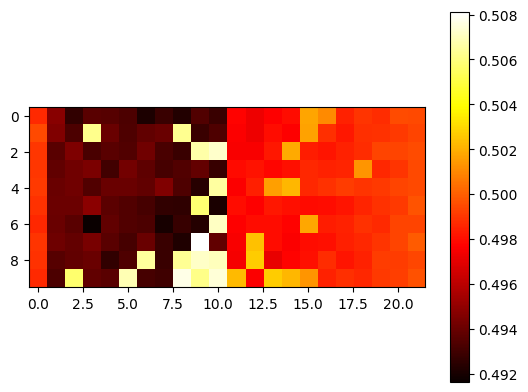

In [147]:
plt.imshow(p[1:,:,0], cmap='hot')
plt.colorbar();

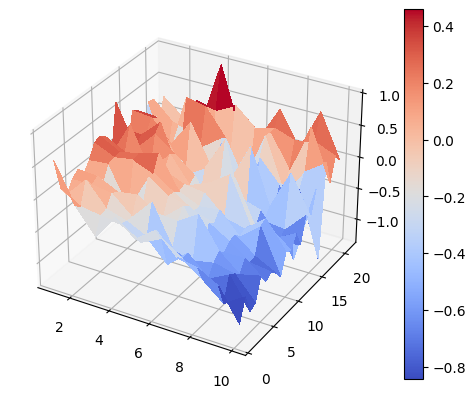

In [148]:
X = np.arange(1, 11, 1)
Y = np.arange(1, 22, 1)
X, Y = np.meshgrid(X, Y)
Z = np.sum(q, axis=2)[X, Y]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf);